# Initiative Analysis for Vision Zero

> 1. Connect to your Hub
> 2. Get crashes, DC wards, merge -> publish collisionLens layer
> 3. Add it as a derived indicator

In [1]:
#Import packages
from arcgishub import hub
from arcgis import GIS
from arcgis.features import *
import pandas as pd

### User-defined inputs

In [2]:
#User-defined inputs
org_url = "https://dc.mapsqa.arcgis.com/"
initiative_id = '75511dbc05dd434ea1885ea1640f8450'
username = username
password = password
start_date = '2018-01-01 00:00:00'
end_date = '2019-01-01 00:00:00'

### 1. Connect to your Hub

In [3]:
myHub = hub.Hub(org_url, username, password)

In [4]:
gis = GIS(org_url, username, password)

In [5]:
#Search for initiative by name
vz_analytics = myHub.initiative_search(initiative_id = initiative_id)
vz_analytics

[{'id': '75511dbc05dd434ea1885ea1640f8450',
  'owner': 'dcadminqa',
  'created': '01-15-2019 -- 12:39:15',
  'modified': '01-25-2019 -- 14:16:51',
  'title': "Manushi's Vision Zero - Adopted from Template",
  'description': 'Create your own initiative by combining existing applications with a custom site.',
  'url': 'https://hubqa.arcgis.com/admin/initiatives/75511dbc05dd434ea1885ea1640f8450',
  'tags': ['Hub Initiative']}]

In [6]:
#Access indicators
vz_indicators = myHub.indicator_layers(initiative_id)
vz_indicators

[{'id': 'wardBoundary',
  'url': 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/31',
  'itemId': '22f727d281ed4bebb631b477aef091c2',
  'name': 'Ward - 2012'},
 {'id': 'streetCrashes',
  'url': 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Public_Safety_WebMercator/MapServer/24',
  'itemId': 'ad20e417ef124914901c26ed46e154bc',
  'name': 'DC_Crashes_VZ_analysis'},
 {'id': 'demographics',
  'url': 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/AGOL_Base_2018_Final/FeatureServer/3',
  'itemId': '72f186389cb849e882b56af7aa1e546b',
  'name': 'Popular Demographics in the United States - Zip Code'},
 {'id': 'surveyCrashes',
  'url': 'https://servicesqa.arcgis.com/97KLIFOSt5CxbiRI/arcgis/rest/services/survey123_215eab1c62054b4dad8d0bb18f11b1dd_stakeholder/FeatureServer/0',
  'itemId': 'b8df9fd50fc546ec854a6ff509b41073',
  'name': 'surveyPoint'}]

In [7]:
len(vz_indicators)

4

### 2.1 Crashes for DC

In [8]:
#Fetch crashes
crashes_url = next(indicator['url'] for indicator in vz_indicators if indicator["id"] == "streetCrashes")
crashes_layer = FeatureLayer(crashes_url)
crashes_features = crashes_layer.query()
crashes = crashes_features.sdf
crashes.shape

(198488, 53)

In [9]:
#Filter based on timestamp
crashes_2018 = crashes[(crashes['FROMDATE'] > start_date) & (crashes['FROMDATE'] < end_date)]
crashes_2018.shape

(26502, 53)

In [10]:
#Compute 'Total Injuries' and 'Total Fatalities'
crashes_2018['Total_Injuries'] = crashes_2018.apply(lambda row: row['MAJORINJURIES_BICYCLIST'] + row['MAJORINJURIES_DRIVER'] + row['MAJORINJURIES_PEDESTRIAN'] + row['MINORINJURIES_BICYCLIST'] + row['MINORINJURIES_DRIVER'] + row['MINORINJURIES_PEDESTRIAN'] + row['UNKNOWNINJURIES_BICYCLIST'] + row['UNKNOWNINJURIES_DRIVER'] + row['UNKNOWNINJURIES_PEDESTRIAN'], axis=1)
crashes_2018['Total_Fatalities'] = crashes_2018.apply(lambda row: row['FATAL_BICYCLIST'] + row['FATAL_PEDESTRIAN'] + row['FATAL_DRIVER'], axis=1)

C:\Users\manu9321\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\manu9321\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#Limit to columns of Interest
crashes_2018_ward = crashes_2018[['WARD', 'Total_Injuries', 'Total_Fatalities']]
crashes_2018_ward.reset_index(inplace=True)

In [12]:
#Group by Ward name
crashes_2018_ward_counts = crashes_2018_ward.groupby('WARD').agg({'Total_Injuries':'sum', 'Total_Fatalities':'sum'}).reset_index()

### 2.2 Wards of DC

In [13]:
wards_url = next(indicator['url'] for indicator in vz_indicators if indicator["id"] == "wardBoundary")
wards_layer = FeatureLayer(wards_url)
wards_features = wards_layer.query()
wards = wards_features.sdf
wards.shape

(8, 83)

In [14]:
#Merge collision counts by ward with Ward geometries
crashes_ward = pd.merge(wards, crashes_2018_ward_counts, left_on='NAME', right_on='WARD')

In [15]:
#Limit to necessary columns
crashes_ward = crashes_ward[['SHAPE', 'NAME', 'Total_Injuries', 'Total_Fatalities']]

### 2.3 Publish collision lens derived indicator

In [16]:
#Publish to org
DC_CollisionLens = gis.content.import_data(crashes_ward, title='DC_NewCollisionLens3')

<Item title:"DC_NewCollisionLens3" type:Feature Layer Collection owner:dcadminqa>
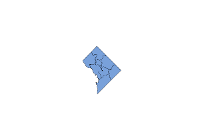

In [18]:
#Verifying 
search_result = gis.content.search("DC_NewCollisionLens3")
search_result[0]

In [19]:
#Set indicator parameters
new_item_id = search_result[0].itemid
new_item_name = search_result[0].title
new_item_url = search_result[0].url + '/0'

### 3. Add it as a derived indicator

In [20]:
collisionLens_indicator = {'id': 'collisionLens','name': 'collisionLens','type': 'Data','optional': 'true','definition': {'supportedTypes': ['FeatureLayer'],'geometryTypes': ['esriGeometryPolygon']},'source': {'type': 'FeatureLayer','url': new_item_url,'itemId': new_item_id,'name': new_item_name, "mappings": [{'id': 'totalFatalities','name': 'Total_Fata','alias': 'Total_Fata','type': 'esriFieldTypeInteger'},{'id': 'totalInjuries','name': 'Total_Inju','alias': 'Total_Inju','type': 'esriFieldTypeInteger'}]}}

In [21]:
myHub.add_derived_indicator(initiative_id=initiative_id, indicator_object=collisionLens_indicator)

True

In [22]:
vz_indicators = myHub.indicator_layers(initiative_id)

In [23]:
len(vz_indicators)

5